<a href="https://colab.research.google.com/github/prog815/abscur_prediction/blob/master/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D1%83%D0%B5%D0%BC_%D1%81_%D0%BF%D0%BE%D0%B4%D0%B1%D0%BE%D1%80%D0%BE%D0%BC_%D0%B3%D0%B8%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%BE%D0%B2_%D0%BD%D0%B0_%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D0%BE%D0%BC_%D0%BB%D0%B5%D1%81%D0%B5(RandomForestClassifier_multiout)_%D0%B7%D0%BD%D0%B0%D0%BA_%D0%BE%D1%82%D0%BD%D0%BE%D1%81%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D1%85_%D0%B8%D0%B7%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B9_%D0%B0%D0%B1%D1%81%D0%BE%D0%BB%D1%8E%D1%82%D0%BD%D1%8B%D1%85_%D0%B2%D0%B0%D0%BB%D1%8E%D1%82%D0%BD%D1%8B%D1%85_%D0%BA%D1%83%D1%80%D1%81%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Прогнозируем с подбором гиперпараметров на случайном лесе(RandomForestClassifier-multiout) знак относительных изменений абсолютных валютных курсов**

**Абсолютный курс**

Енин А.В.

г. Оренбург

2020 г.

Сайт - http://www.abscur.ru

Twitter - https://twitter.com/abscurs

ВКонтакте -  https://vk.com/abscur

Одноклассники -  https://ok.ru/group/53547043520717

FB -  https://www.facebook.com/abscur 

Telegram - https://t.me/AbsCur

GitHub - https://github.com/prog815/abscur_prediction

WhatsUp - https://chat.whatsapp.com/KrNJXAKizPxDlDSjYfdpQs

Viber - https://invite.viber.com/?g2=AQB63y7Cm%2BNJK0tNZW%2F9kI00M6Wr8HuZ7XeamzN4jZCve8Aq9%2FiD3DY56Eqcf7dc

Подбираем гиперпараметры. Прогнозируем знак относительных изменений абсолютного курса. Для этого применяем модель случайного леса (RandomForestClassifier-multiout) по предыдущим значениям (с некоторым окном) относительных изменений абсолютного курса.

# Библиотеки

In [9]:
import datetime
print('[{}]'.format(datetime.date.today()))

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import *
from sklearn.model_selection import *
from sklearn.metrics import *

[2020-04-07]


# Импорт данных

Таблица с историей абсолютных курсов: https://docs.google.com/spreadsheets/d/1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs/edit#gid=422799220

In [10]:
data_url = 'https://docs.google.com/spreadsheets/d/1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs/export?format=csv&id=1_-cdNCIC6NgyRDj0zLJBaohXo-K8qCfxfDLbYq2JLhs&gid=422799220'
abs_data = pd.read_csv(data_url,decimal=',',parse_dates=True,index_col=0)
abs_data.shape

(1312, 45)

# Подготовка данных

Вычисляем матрицу относительных изменений абсолютных валютных курсов

In [0]:
dates = abs_data.index.values # даты
cur_names = abs_data.columns.values # имена валют
data = abs_data.values # матрица абсолютных курсов
d_data = np.zeros_like(data) # матрица относительных изменений
d_data[1:,:] = (data[1:,:]-data[:-1,:])/data[:-1,:] # расчет матрицы относительных изменений

# Готовим входы и выходы модели

Нормируем относительные изменения.
Сибираем матрицу входов и выходов для модели прогнозирования.

In [0]:
window = 30 # окно для входов

y = d_data.copy()

y = (y - y.mean(axis=0)) / y.std(axis=0) # нормируем

x_ = [0]*window

for w in range(window):
    x_[w] = np.zeros_like(y)
    x_[w][(1+w):,:] = y[:(-1-w),:]

X = np.concatenate(x_,axis=1)[window:,:]
y = y[window:]
y = np.array(y >= 0,dtype=float) # бинаризируем

In [13]:
X.shape,y.shape

((1282, 1350), (1282, 45))

# Одна модель для всех валют

## Учим классификатор в одной модели для всех валют

Используем стандартный пакет **scikit-learn**

**RandimForest классификатор:** https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforest#sklearn.ensemble.RandomForestClassifier

Одна модель со многими выходами.

**Ищем параметры на GridSearchCV:** https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html





In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False)
                                # разделяем выборки обучающую и тестовую

clf = GridSearchCV(RandomForestClassifier(),
                   {'n_estimators':np.linspace(5,50,10,dtype=int), 
                                # варьируем размер ансамбля
                    'max_depth':np.linspace(2,20,10,dtype=int)}, 
                                # варьируем глубину деревьев   
                   verbose=10,  # выводим 10 результатов в процессе поиска                                  
                   n_jobs=-1,   # используем многопроцессорность                                       
                   cv=5,        # используем кроссвалидацию 
                   scoring=make_scorer(f1_score,average='weighted'),
                                # скор берем по F1 норме
                   return_train_score=True)

clf.fit(X_train,y_train)        # учим 

print(clf)

preds_train = clf.predict(X_train)
                                # результат на обучающей выборке
preds_test = clf.predict(X_test)
                                # результат на тестовой выборке

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   46.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  2

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [64]:
print('лучшие параметры',clf.best_params_)

лучшие параметры {'max_depth': 18, 'n_estimators': 15}


## Метрики на всех

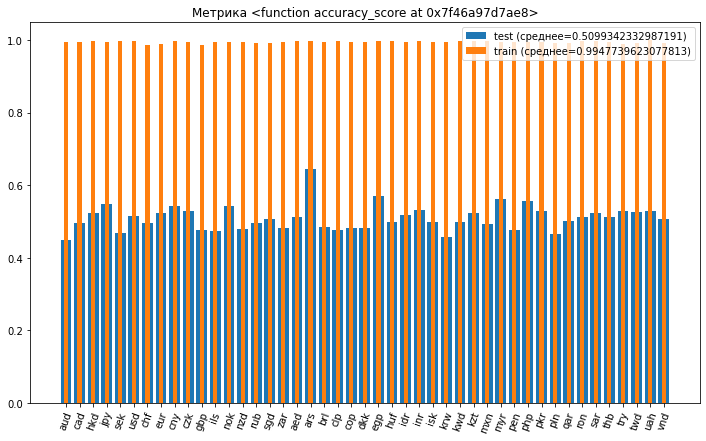

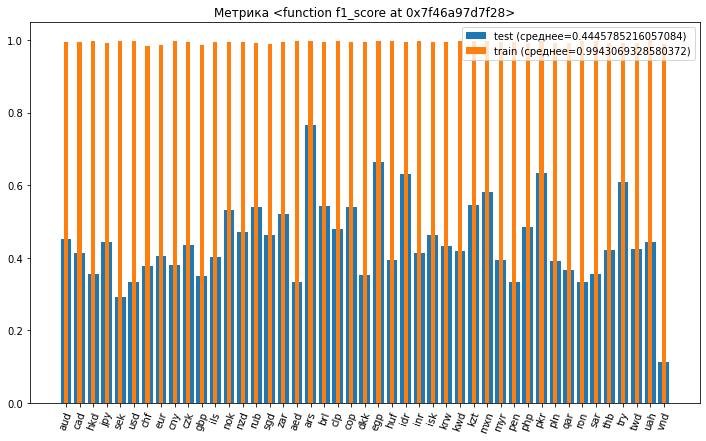

In [65]:
def my_metric(metric_func):
    train_ = [metric_func(y_train[:,k],preds_train[:,k]) for k in range(y.shape[1])]
    test_ = [metric_func(y_test[:,k],preds_test[:,k]) for k in range(y.shape[1])]

    plt.figure(figsize=(12,7))
    plt.bar(cur_names,test_,label="test (среднее={})".format(np.mean(test_)))
    plt.bar(cur_names,train_,width=0.3,label="train (среднее={})".format(np.mean(train_)))
    plt.xticks(rotation=70)
    plt.legend()
    plt.title("Метрика {}".format(metric_func))
    plt.show()

my_metric(accuracy_score)
my_metric(f1_score)


Модель попыталась поднять качество на всех валютах вместе. Общее среднее тестовое качество поднялось, но не перешло за 0.5. 

Можно предположить, что если искать гиперпараметры для каждой валюты по отдельности, то можно добиться лучшего общего результата.